## Statistical Methods

- Flag the data points that deviate from the expected, based on the statistical properties, such as mean, median, mode, and quantiles.
- You could define an anomalous data point as one that deviates by a certain standard deviation from the mean.
- You could use a simple or exponential moving average to smooth short-term fluctuations and highlight long-term ones.
- This method is challenging with really noisy data.


In [1]:
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import linspace, loadtxt, ones, convolve
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import collections
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

## Acquire

In [4]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)


## Prepare

In [5]:
# Parse Datetime

df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

In [6]:
# Clean up text

for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [7]:
# Add variable: converting bytes to mb

df['size_mb'] = [n/1024/1024 for n in df['size']]
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


## Setup time intervals and handle missing datetimestamps
- resample to 30 minute intervals taking max of size
- fill in missing datetimestamps (those not present because no data was captured during that time. We want to have continuous time and those time periods filled with 0)


In [9]:
my_datetime_fmt = mdates.DateFormatter('%m-%d %H:%T')

df_ts_size = df['size_mb'].resample('30T').max()

idx = pd.date_range(
    df_ts_size.sort_index().index.min(), 
    df_ts_size.sort_index().index.max(),
    freq='30min'
)

df_ts_size = df_ts_size.reindex(idx, fill_value=0).fillna(value=0)


## Split into test and train

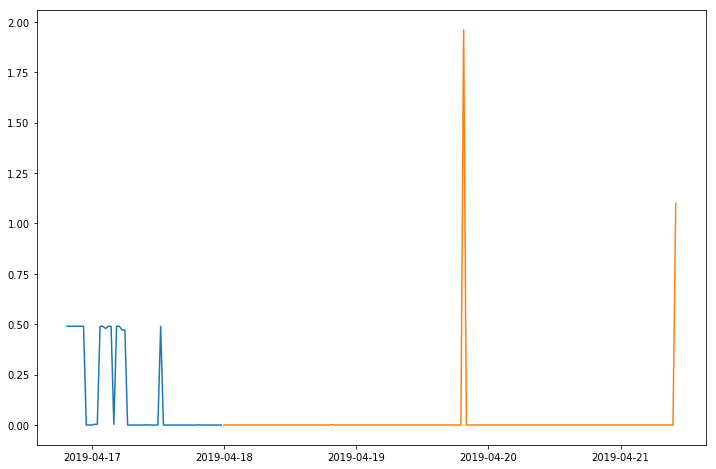

In [10]:
start_date_train = df_ts_size.head(1).index[0]
end_date_train = '2019-04-17 23:30:00'
start_date_test = '2019-04-18 00:00:00'

train = df_ts_size[:end_date_train]
test = df_ts_size[start_date_test:]

plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(test)
plt.show()

## SMA - Simple Moving Average

In [11]:
# Calculating the short-window simple moving average
short_rolling = train.rolling(window=12).mean()

# Calculating the long-window simple moving average
long_rolling = train.rolling(window=24).mean()

## Plot the 2 window sizes for the SMA

Text(0, 0.5, 'Size (MB)')

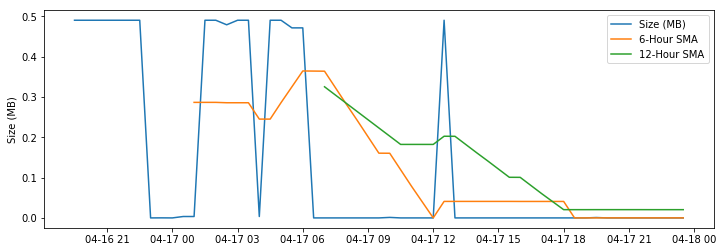

In [13]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')
# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)



## Exponential Moving Average

In [15]:
# Using Pandas to calculate a 2 hour span EMA. 
# adjust=False specifies that we are interested in the 
# recursive calculation mode.
ema_short = train.ewm(span=12, adjust=False).mean()
ema_short[0:3]

ema_long = train.ewm(span=12, adjust=False).mean()
ema_long[0:3]

span = 24
ema_long = train.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3


## Compare SMA with EMA

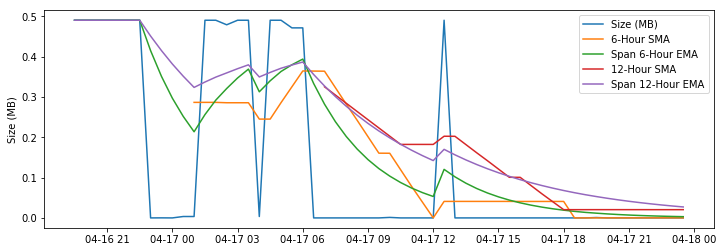

In [16]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span 6-Hour EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span 12-Hour EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

yhat = pd.DataFrame(dict(actual=test))


In [ ]:
## Forecasting using the EMA

In [18]:
span = 24
ema_long = train.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

yhat['moving_avg_forecast'] = midband


## Compute the '%b' for each record

In [19]:
# compute the absolute error:
yhat['error'] = abs(yhat.actual - yhat.moving_avg_forecast)

# compute the mean of the absolute error:
# yhat.error.median()

# compute upper band and lower band using IQR with weight of 3

yhat['pct_b'] = (yhat.actual-lb)/(ub-lb)

## Extract the anomalies

In [20]:
yhat[yhat.pct_b > 1]

,actual,moving_avg_forecast,error,pct_b
2019-04-19 19:30:00+00:00,1.961066,0.02718,1.933886,7.884371
2019-04-21 10:00:00+00:00,1.099591,0.02718,1.072411,4.594905


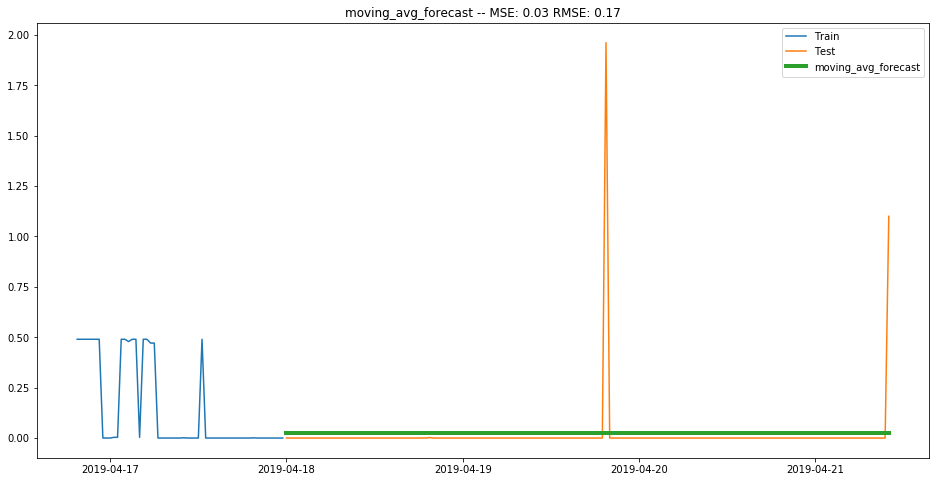

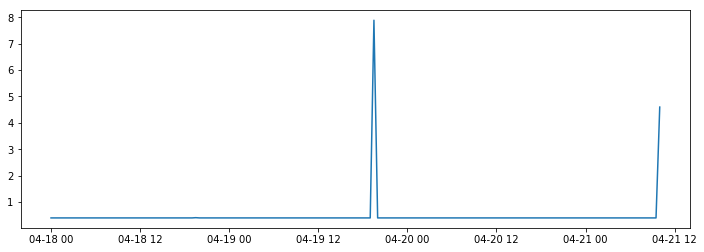

In [21]:
plot_and_eval(yhat.moving_avg_forecast, actual=test)
plt.figure(figsize=(12,4))
plt.plot(yhat.pct_b)
